In [1]:
import firedrake as fd
import matplotlib.pyplot as plt
import numpy as np
import ufl

import hydrogym.firedrake as hgym
from step_response import control_vec, LinearBDFSolver

output_dir = "../eig_output"
# output_dir = "../re40_med_eig_output"
output_dir = "../re100_med_eig_output"
# output_dir = "../re40_fine_eig_output"

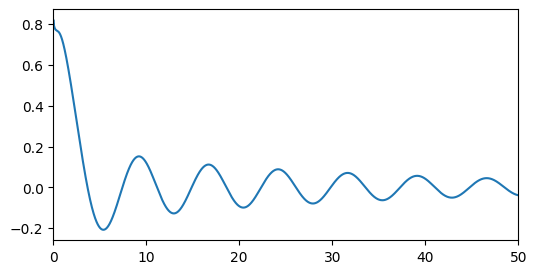

In [2]:
# Load data from model_reduction/step_response.py
step_response = np.load("output/re40_step_response.npy")
t, CL = step_response[:, 0], step_response[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(t, CL, label="CL")
ax.set_xlim([0, 50])
plt.show()


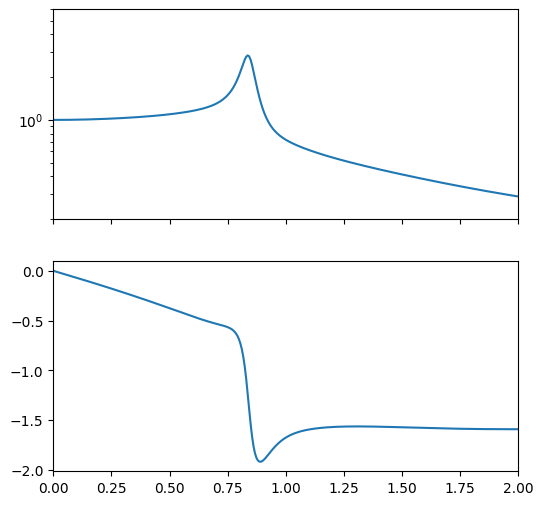

In [3]:
# Fourier transform of the step response
# Compare to transfer_function.ipynb

fs = 1 / (t[1] - t[0])

n = len(CL)
f = 2 * np.pi * np.fft.fftfreq(n, d=1/fs)
CL_fft = np.sqrt(1 / 2 * np.pi) * np.fft.fft(CL) / fs

CL_fft = CL_fft / CL_fft[0]

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(f[:n//2], np.abs(CL_fft[:n//2]))
ax[0].set_ylim(0.2, 6)
ax[1].plot(f[:n//2], np.angle(CL_fft[:n//2]))
ax[1].set_xlim(0, 2)
plt.show()


In [4]:
flow = hgym.RotaryCylinder(
    Re=100,
    velocity_order=2,
    restart=f"{output_dir}/base.h5"
)

qB = flow.q.copy(deepcopy=True)

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


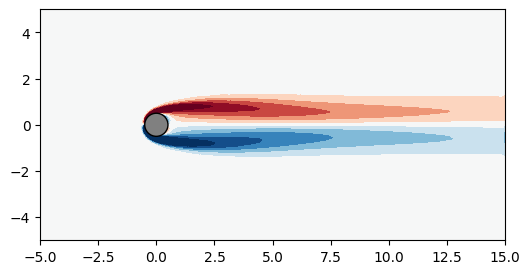

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


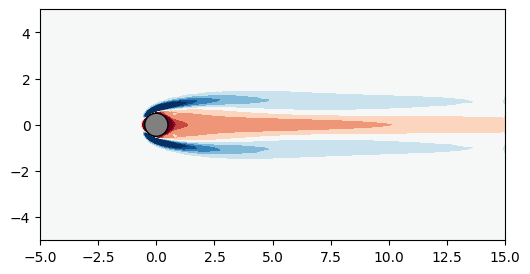

In [6]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure

qC = control_vec(flow)

flow.q.assign(qC)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

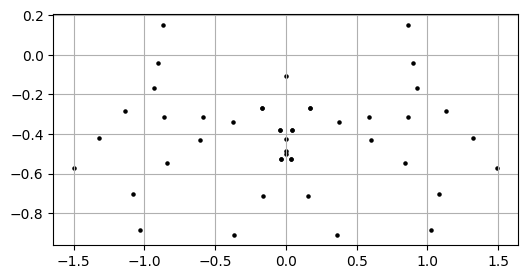

In [7]:
# 3. Global stability
# Plot eigenvalues

evals = np.load(f"{output_dir}/evals.npy")

plt.figure(figsize=(6, 3))
plt.scatter(evals.imag, evals.real, s=5, c='k')
plt.grid()
plt.show()

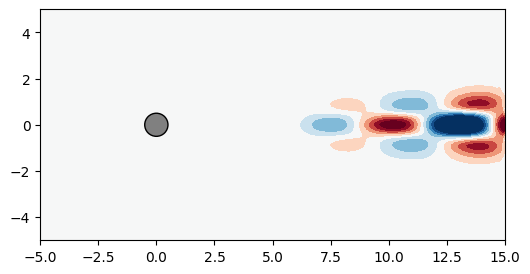

In [8]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-0.5, 0.5))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

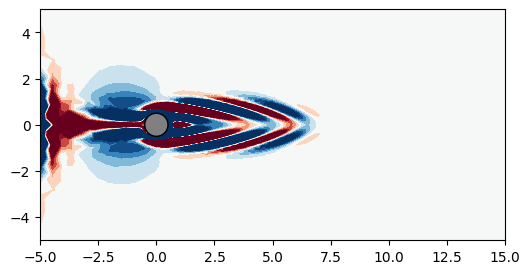

In [9]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-50, 50))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

In [10]:
# Load the set of eigenvectors
r = len(evals)
tol = 1e-10
V = []
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        V.append(q)

W = []
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        W.append(q)


# Sort by real part
sort_idx = np.argsort(-evals.real)
evals = evals[sort_idx]

V = [V[i] for i in sort_idx]
W = [W[i] for i in sort_idx]

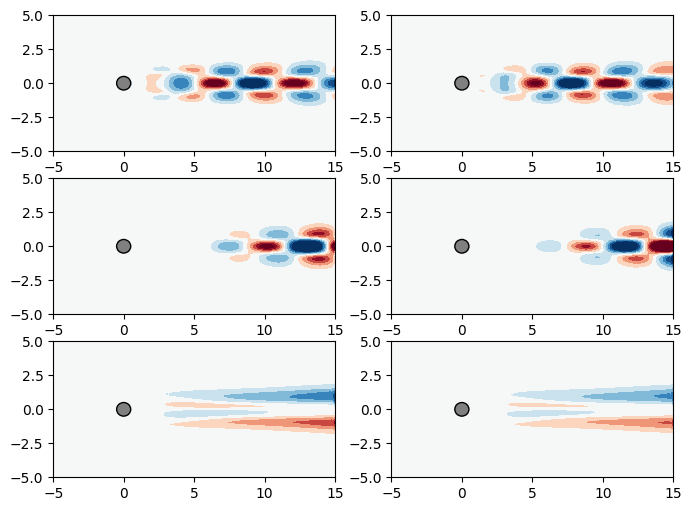

In [11]:
# Plot direct modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

clim = (-0.5, 0.5)
for i in range(0, n_plt):

    # Real part
    flow.q.assign(V[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * V[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

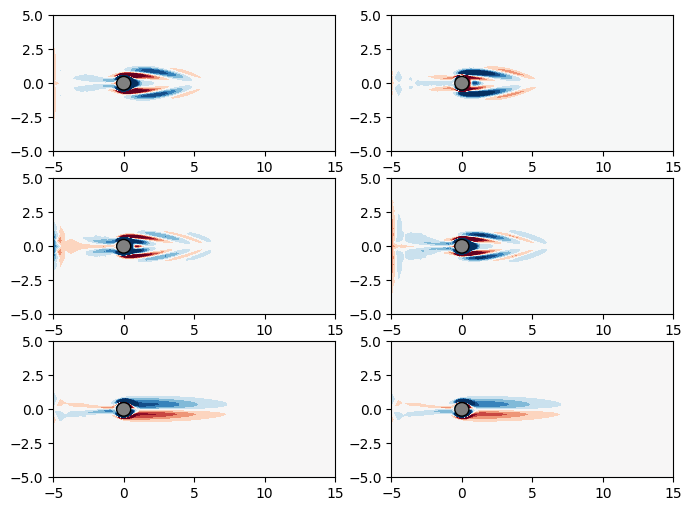

In [12]:
# Plot adjoint modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

for i in range(0, n_plt):

    alpha = flow.inner_product(W[2 * i], W[2 * i])
    clim = np.array([-1, 1]) * np.sqrt(abs(alpha))

    # Real part
    flow.q.assign(W[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * W[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

In [13]:
# 4. Projection onto global modes

r = 17  # Number of global modes for projection
Ar = np.zeros((r, r), dtype=np.complex128)
Br = np.zeros((r, 1), dtype=np.complex128)
Cr = np.zeros((1, r), dtype=np.complex128)

A = flow.linearize(qB)
A.copy_output = True

def meas(q):
    flow.q.assign(q)
    CL, _CD = flow.get_observations()
    return CL

def real_part(q):
    return

for i in range(r):
    for j in range(r):
        # Ar[j, i] = flow.inner_product(A @ V[i], W[j])

        # Specifically for this projection, we know the result is diagonal
        Ar[j, i] = 0.0
        if i == j:
            if np.isclose(evals[i].imag, 0.0, atol=tol):
                Ar[j, i] = evals[i].real
            else:
                Ar[j, i] = evals[i]

    Br[i, 0] = flow.inner_product(qC, W[i])
    Cr[0, i] = meas(V[i])

# Finally the feedthrough term
Dr = meas(qC)

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


[ 0.15105526+0.86674628j  0.15105526-0.86674628j -0.04123425+0.90116992j
 -0.04123425-0.90116992j -0.10587779+0.j         -0.16956155+0.93016196j
 -0.16956155-0.93016196j -0.26713098+0.16929999j -0.26713098-0.16929999j
 -0.26713098-0.16929999j -0.26713098+0.16929999j -0.28530036+1.13381368j
 -0.28530036-1.13381368j -0.31225381-0.58556356j -0.31225381+0.58556356j
 -0.3157637 -0.86457914j -0.3157637 +0.86457914j]
[ 0.15105526+8.66746285e-01j  0.15105526-8.66746285e-01j
 -0.04123425+9.01169923e-01j -0.04123425-9.01169923e-01j
 -0.10587779-2.22044605e-15j -0.16956155+9.30161962e-01j
 -0.16956155-9.30161962e-01j -0.26713098+1.69299992e-01j
 -0.26713098-1.69299992e-01j -0.26713098-1.69299992e-01j
 -0.26713098+1.69299992e-01j -0.28530036+1.13381368e+00j
 -0.28530036-1.13381368e+00j -0.31225381-5.85563557e-01j
 -0.31225381+5.85563557e-01j -0.3157637 -8.64579143e-01j
 -0.3157637 +8.64579143e-01j]


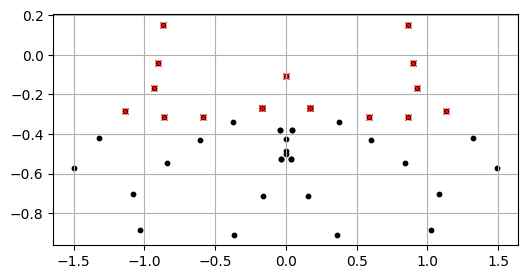

In [14]:
rom_evals = np.linalg.eigvals(Ar)
print(rom_evals)
print(evals[:r])
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(evals.imag, evals.real, s=10, c='k')
ax.scatter(rom_evals.imag, rom_evals.real, s=20, c='r', marker='x', linewidths=1)
ax.grid()

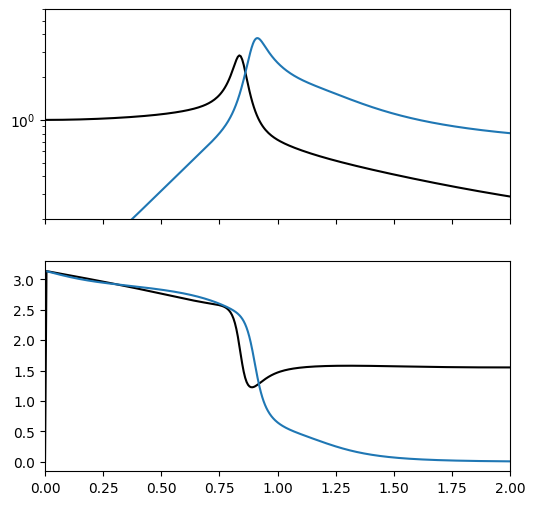

In [15]:
def H(s):
    return Cr @ np.linalg.inv(Ar - s * np.eye(r)) @ Br + Dr

omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(f[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax[0].semilogy(omega.imag, np.abs(H_omega))
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0.2, 6)
ax[1].plot(f[:n//2], np.mod(np.angle(CL_fft[:n//2]), np.pi), 'k')
ax[1].plot(omega.imag, np.angle(H_omega))


In [60]:
# Convert the system to real form
# See: https://github.com/scipy/scipy/blob/v1.12.0/scipy/linalg/_decomp.py#L1458-L1605
from scipy import linalg

def real_form(A, B, C, D):
    w = np.diag(A)
    n = w.shape[-1]

    # get indices for each first pair of complex eigenvalues
    complex_mask = np.iscomplex(w)
    n_complex = complex_mask.sum(axis=-1)

    # find complex indices
    idx = np.nonzero(complex_mask)
    idx_stack = idx[:-1]
    idx_elem = idx[-1]

    # filter them to conjugate indices, assuming pairs are not interleaved
    j = idx_elem[0::2]
    k = idx_elem[1::2]
    stack_ind = ()
    for i in idx_stack:
        # should never happen, assuming nonzero orders by the last axis
        assert (i[0::2] == i[1::2]).all(),\
                "Conjugate pair spanned different arrays!"
        stack_ind += (i[0::2],)

    # all eigenvalues to diagonal form
    Ar = np.zeros((n, n), dtype=w.real.dtype)
    di = range(n)
    Ar[di, di] = w.real

    # complex eigenvalues to real block diagonal form
    Ar[stack_ind + (j, k)] = w[stack_ind + (j,)].imag
    Ar[stack_ind + (k, j)] = w[stack_ind + (k,)].imag

    # compute real eigenvectors associated with real block diagonal eigenvalues
    u = np.zeros((n, n), dtype=np.cdouble)
    u[di, di] = 1.0
    u[stack_ind + (j, j)] = 0.5j
    u[stack_ind + (j, k)] = 0.5
    u[stack_ind + (k, j)] = -0.5j
    u[stack_ind + (k, k)] = 0.5

    # Transform the measurement matrix
    Cr = np.real(C @ u)

    # Transform the input matrix
    Br = np.real(linalg.inv(u) @ B)

    Dr = D.real

    return Ar, Br, Cr, Dr, u


Ar_real, Br_real, Cr_real, Dr_real, T = real_form(Ar, Br, Cr, Dr)

### Controller design

In [61]:
import control

sys = control.ss(Ar_real, Br_real, Cr_real, Dr_real)

dt = 0.01
dt_sys = sys.sample(dt)

# LQR design
Q = np.eye(r)
R = 1e6
K, S, E = control.dlqr(dt_sys, Q, R)

print(K)
print(E)

# Kalman filter design
noise_scale = 1e-6
QN = noise_scale * np.eye(r)
RN = noise_scale
L, P, E = control.dlqe(dt_sys.A, np.eye(r), dt_sys.C, QN, RN)

[[-4.92295171e-01  4.71375168e-02 -5.56139821e-05  2.09185648e-04
   3.21206164e-10  1.33245077e-04 -5.73887991e-05 -6.82507223e-10
   3.78991898e-09 -3.40663296e-09 -1.79559273e-09  1.59634857e-04
  -1.05134901e-05  1.61297489e-05 -7.08121225e-05 -1.45496661e-04
  -2.31810743e-04]]
[0.97529179+0.j         0.98836046+0.j         0.9970311 +0.01114846j
 0.9970311 -0.01114846j 0.99950077+0.00900916j 0.99950077-0.00900916j
 0.99777606+0.00912818j 0.99777606-0.00912818j 0.99845307+0.00865428j
 0.99845307-0.00865428j 0.99684269+0.00587728j 0.99684269-0.00587728j
 0.99894178+0.j         0.99733083+0.00168848j 0.99733083-0.00168848j
 0.99733083+0.00168848j 0.99733083-0.00168848j]


(0.0, 2.0)

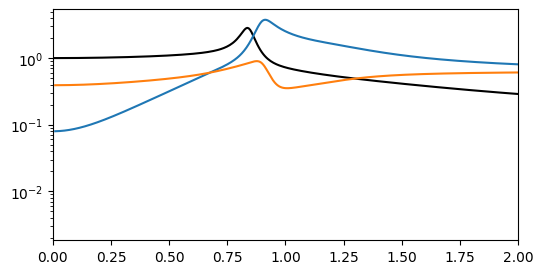

In [62]:
def H_cl(s):
    return sys.C @ np.linalg.inv((sys.A - sys.B @ K) - s * np.eye(r)) @ sys.B + sys.D

# Plot the transfer function
omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])
H_cl_omega = np.array([H_cl(s).ravel() for s in omega])

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
ax.semilogy(f[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax.semilogy(omega.imag, np.abs(H_omega))
ax.semilogy(omega.imag, np.abs(H_cl_omega))
ax.set_xlim(0, 2)

# LQR control only

Full state measurement in the reduced basis by projecting the field at every time step. Intended for debugging only

In [69]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

# Can't have a constant Jacobian here because we need to update the control,
# which changes the assembled matrix via the Dirichlet BC
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=qC, constant_jacobian=False)

tf = 10
n_steps = int(tf // dt)
CL = np.zeros(n_steps)
CD = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# Integrated control signal (this is the BC value)
c = np.zeros((n_steps, m))

flow.q.assign(solver.q)
for i in range(n_steps):
    # Project the flow field onto the reduced basis
    z = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

    # Transform to the real-valued reduced state space
    x[i] = np.real(T @ z)

    # LQR control
    if i > 100:
        u[i] = -K @ x[i]

        # The Dirichlet boundary condition is the integrated control signal
        if i > 0:
            c[i] = c[i-1] + dt * u[i]

        bc_scale = flow.advance_time(dt, c[i])[0].real
        c[i] = np.clip(bc_scale, -flow.MAX_CONTROL, flow.MAX_CONTROL)
        flow.set_control(c[i])

    q = solver.step()
    flow.q.assign(q)
    CL[i], CD[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL[i]:.4f}, CD={CD[i]:.4f}")
        print(f"   u={u[i]}, c={c[i]}")

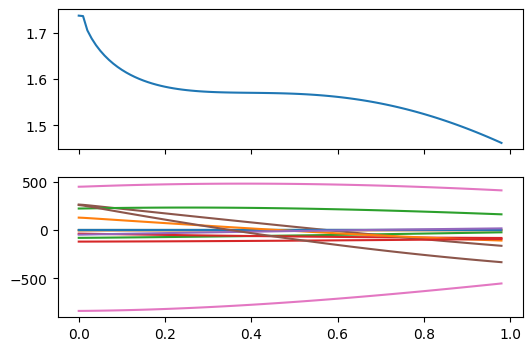

In [67]:
t = np.arange(n_steps) * dt

# y = x @ dt_sys.C.T  # Predicted CL
# print(y.shape)

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(t, CL)
# ax[0].plot(t, y)
ax[1].plot(t, x)
plt.show()


# Full LQG control

In [58]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

# Can't have a constant Jacobian here because we need to update the control,
# which changes the assembled matrix via the Dirichlet BC
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=qC, constant_jacobian=False)

tf = 10
n_steps = int(tf // dt)
CL = np.zeros(n_steps)
CD = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# Integrated control signal (this is the BC value)
c = np.zeros((n_steps, m))

for i in range(n_steps):
    # LQR control
    if i > 0:
        u[i] = -K @ x[i]

        # The Dirichlet boundary condition is the integrated control signal
        if i > 0:
            c[i] = c[i-1] + dt * u[i]

        bc_scale = flow.advance_time(dt, c[i])[0].real
        c[i] = np.clip(bc_scale, -flow.MAX_CONTROL, flow.MAX_CONTROL)
        flow.set_control(c[i])

    q = solver.step()
    flow.q.assign(q)
    CL[i], CD[i] = map(np.real, flow.get_observations())

    # Update Kalman filter state
    y = CL[i]
    # x = dt_sys.A @ x + dt_sys.B @ K @ x + L @ (y - dt_sys.C @ x)
    y_hat = dt_sys.C @ x[i]
    if i < n_steps - 1:
        x[i+1] = dt_sys.A @ x[i] + dt_sys.B @ u[i] + L @ (y - y_hat)

    if i % 10 == 0:
        print(f"t={i*dt:.2f}, CL={CL[i]:.4f}, CD={CD[i]:.4f}")
        print(f"   y_hat={y_hat}, u={u[i]}")

t=0.00, CL=1.7369, CD=-0.0014
   y_hat=[0.], u=[0.]
t=0.10, CL=1.7486, CD=-0.0000
   y_hat=[0.29251455], u=[-11.87083937]
t=0.20, CL=1.9888, CD=-0.0000
   y_hat=[0.5103877], u=[-19.05402217]
t=0.30, CL=2.3498, CD=0.0000
   y_hat=[0.65053309], u=[-24.64590592]
t=0.40, CL=2.8073, CD=0.0001
   y_hat=[0.7133787], u=[-30.39778042]
t=0.50, CL=3.1495, CD=0.0003
   y_hat=[0.69622098], u=[-37.25813948]
t=0.60, CL=3.1073, CD=0.0003
   y_hat=[0.51529121], u=[-42.68234219]
t=0.70, CL=3.0808, CD=0.0003
   y_hat=[0.14972312], u=[-47.46219174]
t=0.80, CL=3.0497, CD=0.0003
   y_hat=[-0.38715522], u=[-53.07806996]
t=0.90, CL=3.0049, CD=0.0003
   y_hat=[-1.08704663], u=[-60.3612617]
t=1.00, CL=2.9417, CD=0.0003
   y_hat=[-1.94988638], u=[-69.77657218]
t=1.10, CL=2.8588, CD=0.0003
   y_hat=[-2.98463969], u=[-81.61738499]
t=1.20, CL=2.7564, CD=0.0003
   y_hat=[-4.20892085], u=[-96.1361643]
t=1.30, CL=2.6359, CD=0.0003
   y_hat=[-5.64833324], u=[-113.62559901]
t=1.40, CL=2.4992, CD=0.0003
   y_hat=[-7.3360

KeyboardInterrupt: 

In [36]:
flow.MAX_CONTROL

1.5707963267948966

(199, 1)


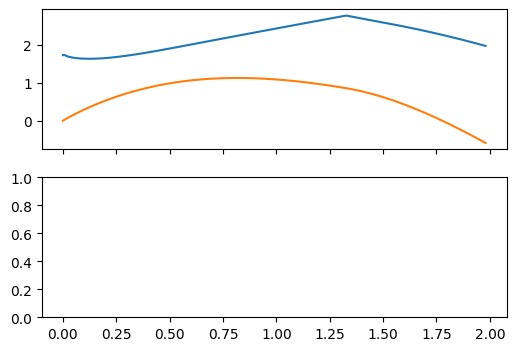

In [53]:
t = np.arange(n_steps) * dt

y = x @ dt_sys.C.T  # Predicted CL
print(y.shape)

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(t, CL)
ax[0].plot(t, y)
# ax[1].plot(t, u)
plt.show()
